# Args

In [3]:
import yaml

In [4]:
gpu_gb_limit = 6

abs_img_folder = r"..//data/UTKFace_Dataset/"
typical_dataset_im_size = (200, 200)

# Imports

## tf

In [ ]:
import tensorflow as tf

### Limit inference GPU

In [ ]:
import tf_mem

In [ ]:
tf_mem.limit_gpu_gb(gpu_gb_limit)

## Non GPU

In [5]:
import sys

sys.path.append("../deepface/")

In [6]:
from glob import glob
from deepface import DeepFace
from tqdm import tqdm
import os
from pathlib import Path

In [ ]:
from src.models.inference import extract_face

# mtcnn (Deepface) on target UTKFace (crops) no bboxes occurance of non-detection

## Infere and store pathes where is no detection

In [26]:
from glob import glob

filenames = sorted(glob(f"{abs_img_folder}/*.jpg"))
print(len(filenames))

23697


In [5]:
backend = "mtcnn"

In [ ]:
pathes_non_detect = []
confidences = []

# for backend in backends_selected:
for img_path_full in tqdm(filenames):
    try:
        face_obj = extract_face(
            img_path_full, typical_dataset_im_size, enforce_detection=True
        )

        n_face = len(face_obj)
        # n_face_arr.append(n_face)
    except:
        face_obj = extract_face(
            img_path_full, typical_dataset_im_size, enforce_detection=False
        )

        filename = os.path.basename(img_path_full)
        pathes_non_detect.append(filename)
        confidences.append(face_obj[0]["confidence"])

    # print(f'{n_face} found')
    # plot_pred(face_obj)

    # break

### store non-detected

In [21]:
non_detect_storage = f"{backend}_no_detect_UTKFace.yaml"

with open(non_detect_storage, "w") as file:
    yaml.dump(pathes_non_detect, file)

## Load non-detected

In [ ]:
non_detect_storage = f"{backend}_no_detect_UTKFace.yaml"

with open(non_detect_storage, "r") as file:
    pathes_non_detect = yaml.safe_load(file)
pathes_non_detect

In [27]:
occurance_score = 1 - len(pathes_non_detect) / len(filenames)
occurance_score

0.989323543064523

# mtcnn (Deepface) on additional FDDB with bboxes

In [8]:
img_nested_folder = r"../data/FDDB/img_nested/"
annot_nested_folder = r"../data/FDDB/annotation/"

In [10]:
import os

jpg_files = []

# Use the os.walk() function to traverse through nested folders
for folder_path, subfolders, filenames in os.walk(img_nested_folder):
    for filename in filenames:
        if filename.lower().endswith(".jpg"):
            # Append the full path of JPG files to the list
            jpg_files.append(os.path.join(folder_path, filename))

In [12]:
jpg_files[:4]

['../data/FDDB/img_nested/2003/06/16/big/img_157.jpg',
 '../data/FDDB/img_nested/2003/06/16/big/img_273.jpg',
 '../data/FDDB/img_nested/2003/06/16/big/img_384.jpg',
 '../data/FDDB/img_nested/2003/06/16/big/img_249.jpg']

In [19]:
jpg_files[0].split(r"/", 4)[4]

'2003/06/16/big/img_157.jpg'

In [20]:
typical_dataset_im_size = (200, 200)

In [22]:
sys.path.append("../")
import src.models.inference as inference

In [28]:
from tqdm import tqdm

## Infer

In [ ]:
im_path_paredict_dict = {}
for jpg_fullpath in tqdm(jpg_files):
    im_id = jpg_fullpath.split(r"/", 4)[4]
    extraction_obj = inference.extract_face(
        jpg_fullpath,
        enforce_detection=False,
        typical_dataset_im_size=typical_dataset_im_size,
    )
    im_path_paredict_dict[im_id] = []
    for face_obj in extraction_obj:
        del face_obj["face"]
        im_path_paredict_dict[im_id].append(face_obj)

 11%|███▉                                | 3126/28204 [11:11<1:21:14,  5.14it/s]

In [30]:
import json

with open("./evaluation_data/FDDB_preds_by_mtcnn.json", "w") as f:
    json.dump(im_path_paredict_dict, f)

## Score

In [36]:
anot_files = sorted(glob(f"{annot_nested_folder}/*ellipseList.txt"))
print(len(anot_files))

10


In [35]:
im_path_paredict_dict["2003/06/16/big/img_273.jpg"]

[{'facial_area': {'x': 218, 'y': 24, 'w': 68, 'h': 93},
  'confidence': 0.9997690320014954},
 {'facial_area': {'x': 83, 'y': 25, 'w': 67, 'h': 86},
  'confidence': 0.999381422996521}]

In [70]:
def compute_iou(x1, y1, w1, h1, x2, y2, w2, h2) -> float:
    x_min = max(x1 - w1 / 2, x2 - w2 / 2)
    x_max = min(x1 + w1 / 2, x2 + w2 / 2)
    y_min = max(y1 - h1 / 2, y2 - h2 / 2)
    y_max = min(y1 + h1 / 2, y2 + h2 / 2)

    if x_max <= x_min or y_max <= y_min:
        return 0.0

    intersection_area = (x_max - x_min) * (y_max - y_min)
    union_area = (w1 * h1) + (w2 * h2) - intersection_area

    return intersection_area / union_area

In [116]:
def get_box_from_ellipe(ellipse_arr):
    """FDDB format is special

    ra: радиус большой оси эллипса
    rb: радиус малой оси эллипса
    тета: угол отклонения большой оси эллипса
    cx: координата x центра эллипса
    cy: y координата центра эллипса
    conf: достоверность метки
    """
    ra, rb, theta, cx, cy, conf = ellipse_arr

    bbox_x = cx - ra
    bbox_y = cy - rb
    bbox_width = 2 * ra
    bbox_height = 2 * rb

    # Create a rotation matrix
    rotation_matrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )

    # Calculate the rotated corner coordinates of the bounding box
    corner_coords = np.array(
        [
            [-bbox_width / 2, -bbox_height / 2],
            [bbox_width / 2, -bbox_height / 2],
            [bbox_width / 2, bbox_height / 2],
            [-bbox_width / 2, bbox_height / 2],
        ]
    )

    rotated_corner_coords = corner_coords.dot(rotation_matrix.T)
    rotated_corner_x = rotated_corner_coords[:, 0] + cx
    rotated_corner_y = rotated_corner_coords[:, 1] + cy

    bbox_x = np.min(rotated_corner_x)
    bbox_y = np.min(rotated_corner_y)
    bbox_width = np.max(rotated_corner_x) - bbox_x
    bbox_height = np.max(rotated_corner_y) - bbox_y

    return bbox_x, bbox_y, bbox_width, bbox_height

In [132]:
def compute_detection_scores_for_multiple_files(annotations_files, im_path_pred_dict):
    all_detection_scores = {}

    for annotations_file in annotations_files:
        # print('opened')
        with open(annotations_file, "r") as f:
            lines = f.readlines()
            for line in lines:
                if r"/" in line:  # .strip().endswith('.jpg'):
                    img_path = line.strip()
                    # print(img_path)
                    num_faces = int(lines[lines.index(line) + 1])
                    for _ in range(num_faces):
                        ellipse_data = list(
                            map(float, lines[lines.index(line) + 2 + _].strip().split())
                        )

                        # print(ellipse_data)
                        bbox_x, bbox_y, bbox_width, bbox_height = get_box_from_ellipe(
                            ellipse_data
                        )

                        img_with_ext = f"{img_path}.jpg"

                        predictions = im_path_pred_dict.get(img_with_ext, [])
                        # print(predictions==[])
                        best_iou_score = 0.0
                        best_confidence = 0.0

                        for prediction in predictions:
                            x = prediction["facial_area"]["x"]
                            y = prediction["facial_area"]["y"]
                            w = prediction["facial_area"]["w"]
                            h = prediction["facial_area"]["h"]

                            iou_score = compute_iou(
                                bbox_x, bbox_y, bbox_width, bbox_height, x, y, w, h
                            )

                            if iou_score > best_iou_score:
                                best_iou_score = iou_score
                                best_confidence = prediction["confidence"]

                        all_detection_scores[img_with_ext] = {
                            "iou_score": best_iou_score,
                            "confidence": best_confidence,
                        }

    return all_detection_scores

In [133]:
scores = compute_detection_scores_for_multiple_files(anot_files, im_path_paredict_dict)

In [ ]:
scores

In [130]:
def mean_dict_scores(score_dict):
    return sum([val["iou_score"] for key, val in score_dict.items()]) / len(score_dict)

In [135]:
mean_dict_scores(scores)

0.4860722517357339

## Check on one image

In [69]:
im_path_paredict_dict["2002/08/02/big/img_51.jpg"]

[{'facial_area': {'x': 98, 'y': 135, 'w': 129, 'h': 159},
  'confidence': 0.9749870300292969}]

In [82]:
image_path = f"{img_nested_folder}/2002/08/02/big/img_51.jpg"

In [108]:
rotated_corner_x, rotated_corner_y

(array([ 86.34074893,  90.73659528, 235.71108907, 231.31524272]),
 array([296.08343625,  35.30949184,  37.75331575, 298.52726016]))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Example data
bbox_data_a = {"x": 98, "y": 135, "w": 129, "h": 159}
ellipse_data_b = [130.405496, 72.497545, -1.553941, 161.025919, 166.918376, 1]

# Load the image
image = Image.open(image_path)

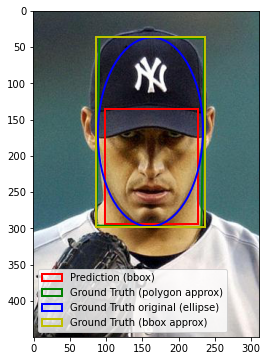

In [121]:
plt.figure(figsize=(8, 6))
plt.imshow(image)

ra, rb, theta, cx, cy, conf = ellipse_data_b

# Plot bounding box (format A)
bbox_a = patches.Rectangle(
    (bbox_data_a["x"], bbox_data_a["y"]),
    bbox_data_a["w"],
    bbox_data_a["h"],
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label="Prediction (bbox)",
)

bbox_x, bbox_y, bbox_width, bbox_height = get_box_from_ellipe(ellipse_data_b)

bbox_c = patches.Rectangle(
    (bbox_x, bbox_y),
    bbox_width,
    bbox_height,
    linewidth=2,
    edgecolor="y",
    facecolor="none",
    label="Ground Truth (bbox approx)",
)


ellipse = patches.Ellipse(
    (cx, cy),
    2 * ra,
    2 * rb,
    angle=np.degrees(theta),
    linewidth=2,
    edgecolor="b",
    facecolor="none",
    label="Ground Truth original (ellipse)",
)

plt.gca().add_patch(bbox_a)
plt.gca().add_patch(ellipse)
plt.gca().add_patch(bbox_c)


# Display the plot with legend
plt.legend()
plt.show()

In [122]:
bbox_data_a["x"], bbox_data_a["y"],
bbox_data_a["w"], bbox_data_a["h"],

bbox_x, bbox_y, bbox_width, bbox_height

compute_iou(
    bbox_data_a["x"],
    bbox_data_a["y"],
    bbox_data_a["w"],
    bbox_data_a["h"],
    bbox_x,
    bbox_y,
    bbox_width,
    bbox_height,
)

0.31146385277507255

# Вывод

Лица находит гораздо лучше разметки в которой размечена эллипсами скорее голова нежели сами лица.
Предсказанные лица больше соответвуют UTKFace_Dataset
и в итоге подходят для определения возраста

## Store configs for best model

In [137]:
detection_dict = dict(
    backend="mtcnn", typical_dataset_im_size=list(typical_dataset_im_size)
)

In [138]:
import yaml

yaml_path = f"../configs/detection.yaml"

with open(yaml_path, "w") as f:
    yaml.dump(
        detection_dict,
        f,
        allow_unicode=True,  # makes encoding work properly
        encoding="utf8",
        default_flow_style=False,
    )